In [1]:
# import torch
# from src.helper import load_checkpoint, init_model

In [2]:
# # Specify the path to your trained checkpoint file
# checkpoint_path = '/home/paritosh/workspace/ijepa_saved_models/jepa-latest.pth.tar'

# # Initialize the device (e.g., 'cuda' or 'cpu')
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Load the checkpoint
# checkpoint = torch.load(checkpoint_path, map_location=device)

In [3]:
# # Extract the model configuration from the checkpoint
# config = checkpoint['config']

# # # Initialize the device (e.g., 'cuda' or 'cpu')
# # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Extract the relevant parameters from the configuration
# patch_size = config['mask']['patch_size']
# model_name = config['meta']['model_name']
# crop_size = config['data']['crop_size']
# pred_depth = config['meta']['pred_depth']
# pred_emb_dim = config['meta']['pred_emb_dim']

# # Initialize the model components
# encoder, predictor = init_model(
#     device,
#     patch_size=patch_size,
#     model_name=model_name,
#     crop_size=crop_size,
#     pred_depth=pred_depth,
#     pred_emb_dim=pred_emb_dim
# )

# target_encoder = None
# optimizer = None
# scaler = None

# # Load the checkpoint
# encoder, predictor, target_encoder, optimizer, scaler, epoch = load_checkpoint(
#     device,
#     checkpoint_path,
#     encoder,
#     predictor,
#     target_encoder,
#     optimizer,
#     scaler
# )

# # Print the model structure
# print("Encoder:")
# print(encoder)
# print("\nPredictor:")
# print(predictor)

In [4]:
import torch
import yaml
from src.helper import load_checkpoint, init_model

# Specify the path to your trained checkpoint file
checkpoint_path = '/home/paritosh/workspace/ijepa_saved_models/jepa-latest.pth.tar'

# Specify the path to your YAML configuration file
config_path = 'configs/custom1.yaml'

# Load the YAML configuration file
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)

# Initialize the device (e.g., 'cuda' or 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Extract the relevant parameters from the configuration
patch_size = config['mask']['patch_size']
model_name = config['meta']['model_name']
crop_size = config['data']['crop_size']
pred_depth = config['meta']['pred_depth']
pred_emb_dim = config['meta']['pred_emb_dim']

# Initialize the model components
encoder, predictor = init_model(
    device,
    patch_size=patch_size,
    model_name=model_name,
    crop_size=crop_size,
    pred_depth=pred_depth,
    pred_emb_dim=pred_emb_dim
)

target_encoder = None
optimizer = None
scaler = None

# Load the checkpoint
encoder, predictor, target_encoder, optimizer, scaler, epoch = load_checkpoint(
    device,
    checkpoint_path,
    encoder,
    predictor,
    target_encoder,
    optimizer,
    scaler
)

# Print the model structure
print("Encoder:")
print(encoder)
print("\nPredictor:")
print(predictor)

INFO:root:VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(4, 4), stride=(4, 4))
  )
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
)
INFO:root:loaded pretrained encoder from epoch 100
INFO:root:

In [7]:
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
import numpy as np

# Set the encoder to evaluation mode
encoder.eval()

# Define the data transforms
transform = transforms.Compose([
    transforms.Resize((crop_size, crop_size)),
    transforms.ToTensor(),
    # Add any other necessary transforms
])

# Create a dataset and data loader for your images
dataset = ImageFolder(root='/home/paritosh/workspace/IK_contrastive_dataset/synthetic_superhard', transform=transform)

# Determine the number of samples per class
num_samples_per_class = 1000  # Adjust this value according to your needs

# Create a list to store the selected indices
selected_indices = []

# Iterate over each class
for class_idx in range(len(dataset.classes)):
    # Get the indices of samples belonging to the current class
    class_indices = [i for i, (_, label) in enumerate(dataset.samples) if label == class_idx]
    
    # Randomly select num_samples_per_class indices from the class
    selected_class_indices = torch.randperm(len(class_indices))[:num_samples_per_class]
    
    # Map the selected indices to the original dataset indices
    selected_class_indices = [class_indices[i] for i in selected_class_indices]
    
    # Append the selected indices to the list
    selected_indices.extend(selected_class_indices)

# Create a subset of the dataset using the selected indices
subset_dataset = Subset(dataset, selected_indices)

# Create a data loader for the subset dataset
dataloader = DataLoader(subset_dataset, batch_size=128, shuffle=False)

# Extract embeddings
embeddings = []
with torch.no_grad():
    for images, _ in dataloader:
        images = images.to(device)
        batch_embeddings = encoder(images)
        # embeddings.append(batch_embeddings)

        # Average the patch embeddings for each image
        image_embeddings = torch.mean(batch_embeddings, dim=1)
        embeddings.append(image_embeddings.cpu().numpy())

        # # Flatten the patch embeddings for each image
        # image_embeddings = batch_embeddings.view(batch_embeddings.size(0), -1)
        # embeddings.append(image_embeddings)

# embeddings = torch.cat(embeddings, dim=0)
embeddings = np.concatenate(embeddings, axis=0)
print(embeddings.shape)

(7000, 384)


In [8]:
# project embeddings into 2D space
# from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# pca = PCA(n_components=2)
# pca.fit(embeddings)
# pca_embeddings = pca.transform(embeddings)

tsne = TSNE(n_components=2, verbose=1)
tsne_embeddings = tsne.fit_transform(embeddings)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7000 samples in 0.001s...
[t-SNE] Computed neighbors for 7000 samples in 0.404s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7000
[t-SNE] Computed conditional probabilities for sample 2000 / 7000
[t-SNE] Computed conditional probabilities for sample 3000 / 7000
[t-SNE] Computed conditional probabilities for sample 4000 / 7000
[t-SNE] Computed conditional probabilities for sample 5000 / 7000
[t-SNE] Computed conditional probabilities for sample 6000 / 7000
[t-SNE] Computed conditional probabilities for sample 7000 / 7000
[t-SNE] Mean sigma: 0.131350
[t-SNE] KL divergence after 250 iterations with early exaggeration: 91.743195
[t-SNE] KL divergence after 1000 iterations: 2.909173


iVAT Processing: 100%|██████████| 6999/6999 [00:00<00:00, 16844.23it/s]


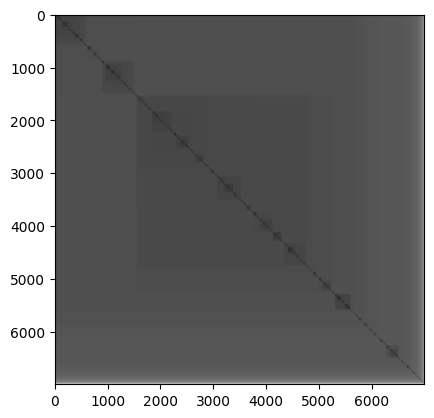

In [10]:
from VAT_library.iVAT import iVAT
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# pairwise_dist = cdist(embeddings, embeddings)
# pairwise_dist = cdist(pca_embeddings, pca_embeddings)
pairwise_dist = cdist(tsne_embeddings, tsne_embeddings)

RiV, RV, reordering_mat = iVAT(pairwise_dist)

plt.imshow(RiV, cmap='gray')
save_path = "/home/paritosh/workspace/ijepa_saved_models/ijepa_first_test/synthetic_superhard_2D.png"  # Specify the path and file name here
plt.savefig(save_path)